In [1]:
import pandas as pd
import numpy as np  
import os

In [2]:
# For reproducibility of results
np.random.seed(0)

# Load the dataset if selected_features.csv does exist
if os.path.exists("selected_features.csv"):
    selected_features = pd.read_csv("selected_features.csv")
    print(selected_features.head())
else:
    print("The dataset is not present in the current directory.")

       2      7      8     11     14     15     17     18     21     22  ...  \
0 -0.684 -0.113  0.401 -0.251 -0.178  0.321  0.016 -0.003 -0.275 -0.162  ...   
1 -0.529 -0.066 -0.168 -0.205  0.020  0.031 -0.165 -0.026 -0.130  0.176  ...   
2 -0.240  0.031 -0.077 -0.036 -0.005  0.170  0.212  0.138 -0.300  0.689  ...   
3 -0.062 -0.143  0.068 -0.295 -0.188 -0.317 -0.113  0.018 -0.272 -0.531  ...   
4 -0.203 -0.168  0.008  0.166 -0.048 -0.291 -0.091  0.062  0.026 -0.036  ...   

      54     56     57     58     59     60     64     66     68  label  
0 -0.263 -0.075 -0.327 -0.198 -0.257 -0.205 -0.223 -0.136 -0.132      0  
1 -0.064  0.004 -0.305 -0.018 -0.230 -0.150 -0.151 -0.031 -0.097      0  
2 -0.149  0.102 -0.189 -0.112 -0.121  0.121 -0.172  0.033 -0.321      0  
3 -0.245 -0.153 -0.405 -0.102 -0.120 -0.141 -0.292 -0.078 -0.151      0  
4  0.043 -0.099 -0.188  0.042 -0.124 -0.097 -0.165 -0.112 -0.138      1  

[5 rows x 31 columns]


In [3]:
labels = selected_features.iloc[:, -1]
features = selected_features.iloc[:, :-1]

features, labels

(            2         7         8        11        14        15        17  \
 0   -0.684000 -0.113000  0.401000 -0.251000 -0.178000  0.321000  0.016000   
 1   -0.529000 -0.066000 -0.168000 -0.205000  0.020000  0.031000 -0.165000   
 2   -0.240000  0.031000 -0.077000 -0.036000 -0.005000  0.170000  0.212000   
 3   -0.062000 -0.143000  0.068000 -0.295000 -0.188000 -0.317000 -0.113000   
 4   -0.203000 -0.168000  0.008000  0.166000 -0.048000 -0.291000 -0.091000   
 ..        ...       ...       ...       ...       ...       ...       ...   
 391 -0.240811  0.160049 -0.172790  0.431347  0.430861 -0.305451 -0.119770   
 392 -0.179418 -0.000023 -0.260852  0.237564 -0.080075 -0.354038 -0.004051   
 393 -0.553610 -0.005744 -0.068708 -0.253044  0.017528 -0.070628 -0.172178   
 394  0.203276 -0.036268 -0.253699  0.382949  0.295444  0.049701 -0.245894   
 395 -0.221108  0.450663 -0.293762  0.042793  0.153844 -0.268618 -0.083691   
 
            18        21        22  ...        53        54   

## Min-Max

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_normalized = scaler.fit_transform(features)
dataset_normalized

array([[0.18304732, 0.49900892, 0.89076305, ..., 0.33932274, 0.34881517,
        0.52682455],
       [0.26365055, 0.52229931, 0.43373494, ..., 0.38908086, 0.44834123,
        0.54374094],
       [0.41393656, 0.5703667 , 0.50682731, ..., 0.37456807, 0.50900474,
        0.43547608],
       ...,
       [0.25085283, 0.55215857, 0.51348755, ..., 0.31353283, 0.41787867,
        0.28746834],
       [0.6444493 , 0.53703271, 0.3649004 , ..., 0.57430339, 0.55802938,
        0.67151474],
       [0.42376079, 0.77832656, 0.33272129, ..., 0.38708569, 0.42213365,
        0.63412131]])

In [5]:
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, log_loss
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# ANN v.final

In [6]:
import warnings

# Suppress specific UserWarning about build_fn
warnings.filterwarnings('ignore', category=UserWarning, message=".*build_fn.*")

In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import keras.backend as K
import tensorflow as tf

In [12]:
class CustomOptimizer(tf.keras.optimizers.legacy.Optimizer):
    def __init__(self, learning_rate=0.01, name="CustomOptimizer", **kwargs):
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))

    def _create_slots(self, var_list):
        pass  # No additional slots are needed for our custom optimizer.

    def _resource_apply_dense(self, grad, var, apply_state=None):
        learning_rate = self._get_hyper("learning_rate")
        var.assign_sub(learning_rate * grad)
        return var

    def get_config(self):
        config = super(CustomOptimizer, self).get_config()
        config.update({
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
        })
        return config

In [9]:
def simple_neuron_model(input_dim, optimizer):
    model = Sequential()
    model.add(Dense(1, input_dim=input_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [10]:
def multi_input_neuron_model(input_dim, optimizer):
    model = Sequential()
    model.add(Dense(1, input_dim=input_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [11]:
def multi_neuron_model(input_dim, num_neurons, optimizer):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=input_dim, activation='sigmoid'))
    # Add more layers if needed
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:

def multilayer_model(input_dim, num_layers, num_neurons_per_layer, activation_function, optimizer):
    model = Sequential()
    model.add(Dense(num_neurons_per_layer[0], input_dim=input_dim, activation=activation_function))
    for neurons in num_neurons_per_layer[1:]:
        model.add(Dense(neurons, activation=activation_function))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:
# Define input dimension based on your features
input_dim = dataset_normalized.shape[1]

# Define a random state for reproducibility
random_state = 0

# Define the parameter grid
param_grid = {
    'model__optimizer__learning_rate': [0.1, 0.3, 0.5],
    'epochs': [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
}

# Define a function to create our custom optimizer with a learning rate placeholder
def custom_optimizer(lr=0.01):
    return CustomOptimizer(learning_rate=lr)

In [14]:

# Now when creating the topologies dictionary, make sure to pass the custom_optimizer function correctly
topologies = {
    'simple_neuron': KerasClassifier(build_fn=lambda: simple_neuron_model(input_dim=input_dim, optimizer=custom_optimizer()), verbose=0),
    'multi_input_neuron': KerasClassifier(build_fn=lambda: multi_input_neuron_model(input_dim=input_dim, optimizer=custom_optimizer()), verbose=0),
    'multi_neuron': KerasClassifier(build_fn=lambda: multi_neuron_model(input_dim=input_dim, num_neurons=10, optimizer=custom_optimizer()), verbose=0),
    'multilayer': KerasClassifier(build_fn=lambda: multilayer_model(input_dim=input_dim, num_layers=3, num_neurons_per_layer=10, activation_function='relu', optimizer=custom_optimizer()), verbose=0)
}
# 3 layers (dense), 12 - 8 - 1 - relu - sigmoid || 500 w/0.1 

In [15]:
# Prepare stratified K-fold
skf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

# Store results
results = {}

# Iterate over each model topology and perform grid search
for name, model in topologies.items():
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
    grid_result = grid.fit(dataset_normalized, labels)  # X and y are our data
    
    # Store the results
    results[name] = {
        'best_score': grid_result.best_score_,
        'best_params': grid_result.best_params_,
        'mean_test_score': grid_result.cv_results_['mean_test_score'],
        'std_test_score': grid_result.cv_results_['std_test_score'],
        'params': grid_result.cv_results_['params']
    }
    
    # Print the best configuration for the current topology
    print(f"Best for {name}: {grid_result.best_score_:.4f} using {grid_result.best_params_}")

2023-11-05 23:40:29.476424: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-05 23:40:29.476449: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-05 23:40:29.476457: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-05 23:40:29.476694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-05 23:40:29.476734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-05 23:40:30.258705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Best for simple_neuron: 0.7363 using {'epochs': 250, 'model__optimizer__learning_rate': 0.5}
Best for multi_input_neuron: 0.7421 using {'epochs': 500, 'model__optimizer__learning_rate': 0.1}
Best for multi_neuron: 0.7267 using {'epochs': 500, 'model__optimizer__learning_rate': 0.5}
Best for multilayer: 0.7571 using {'epochs': 400, 'model__optimizer__learning_rate': 0.3}


In [16]:
# Create an empty list to store the performance table data
performance_table = []

# Iterate over the results to calculate the required metrics
for name, result in results.items():
    for mean, stdev, param in zip(result['mean_test_score'], result['std_test_score'], result['params']):
        performance_table.append({
            'Model': name,
            'Mean AUC': mean,
            'Std AUC': stdev,
            'Parameters': param
        })

# Convert the performance table list to a DataFrame
performance_df = pd.DataFrame(performance_table)

# Display the performance table
print(performance_df)

# Select the best model based on the highest mean AUC score
best_model_info = performance_df.loc[performance_df['Mean AUC'].idxmax()]

# Print the best model information
print("\nBest Model:")
print(best_model_info)

             Model  Mean AUC   Std AUC  \
0    simple_neuron  0.528612  0.063836   
1    simple_neuron  0.530552  0.120975   
2    simple_neuron  0.521647  0.072463   
3    simple_neuron  0.679815  0.123574   
4    simple_neuron  0.629885  0.126311   
..             ...       ...       ...   
127     multilayer  0.728073  0.080161   
128     multilayer  0.719037  0.094520   
129     multilayer  0.730782  0.086104   
130     multilayer  0.731455  0.100485   
131     multilayer  0.729011  0.093871   

                                            Parameters  
0    {'epochs': 1, 'model__optimizer__learning_rate...  
1    {'epochs': 1, 'model__optimizer__learning_rate...  
2    {'epochs': 1, 'model__optimizer__learning_rate...  
3    {'epochs': 50, 'model__optimizer__learning_rat...  
4    {'epochs': 50, 'model__optimizer__learning_rat...  
..                                                 ...  
127  {'epochs': 450, 'model__optimizer__learning_ra...  
128  {'epochs': 450, 'model__optimizer_

In [30]:
# We expect 'learning_rate' to be a parameter for the model building function, not 'model__optimizer__learning_rate'
if 'model__optimizer__learning_rate' in best_model_info['Parameters']:
    model_params['learning_rate'] = best_model_info['Parameters'].pop('model__optimizer__learning_rate')

# Remove any other GridSearchCV specific prefixes that are not expected by the model building function
model_params = {
    k.replace('model__', '').replace('optimizer__', ''): v 
    for k, v in best_model_info['Parameters'].items()
}

# Remove the fitting parameters 'epochs' and 'batch_size' from model_params
fit_params = {k: model_params.pop(k) for k in ['epochs', 'batch_size'] if k in model_params}

# Now build and fit the model
best_model_constructor = topologies[best_model_info['Model']].build_fn
best_estimator = best_model_constructor(**model_params)
history = best_estimator.fit(dataset_normalized, labels, **fit_params)

# Obtain predictions and prediction probabilities
y_pred = best_estimator.predict(dataset_normalized)

Epoch 1/400
13/13 [==============================] - 14s 604ms/step - loss: 0.7553 - accuracy: 0.5101
Epoch 2/400
13/13 [==============================] - 3s 280ms/step - loss: 0.7176 - accuracy: 0.5101
Epoch 3/400
13/13 [==============================] - 2s 173ms/step - loss: 0.6978 - accuracy: 0.5152
Epoch 4/400
13/13 [==============================] - 2s 122ms/step - loss: 0.6874 - accuracy: 0.5278
Epoch 5/400
13/13 [==============================] - 0s 39ms/step - loss: 0.6823 - accuracy: 0.5328
Epoch 6/400
13/13 [==============================] - 1s 94ms/step - loss: 0.6806 - accuracy: 0.5455
Epoch 7/400
13/13 [==============================] - 1s 51ms/step - loss: 0.6765 - accuracy: 0.5682
Epoch 8/400
13/13 [==============================] - 1s 72ms/step - loss: 0.6749 - accuracy: 0.5657
Epoch 9/400
13/13 [==============================] - 0s 13ms/step - loss: 0.6747 - accuracy: 0.5707
Epoch 10/400
13/13 [==============================] - 1s 42ms/step - loss: 0.6728 - accuracy: 0

In [31]:
# To get the predicted probabilities for the positive class (equivalent of predict_proba)
y_pred_proba = best_estimator.predict(dataset_normalized).ravel()

 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 16ms/step


In [32]:
# Assuming that `y_pred_proba` contains the predicted probabilities.
# We will need to apply a threshold to convert these to binary predictions.
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, y_pred_binary)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[139  55]
 [ 49 153]]


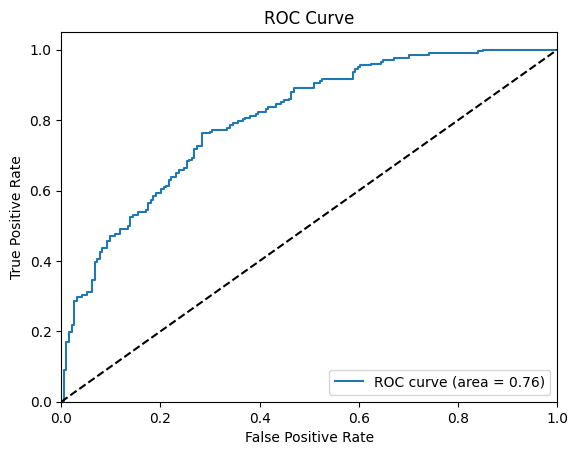

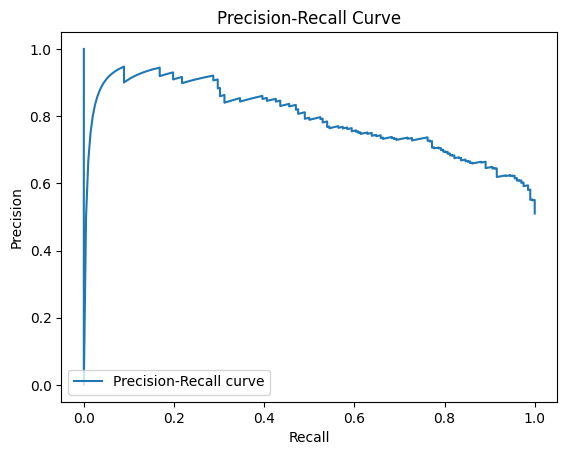

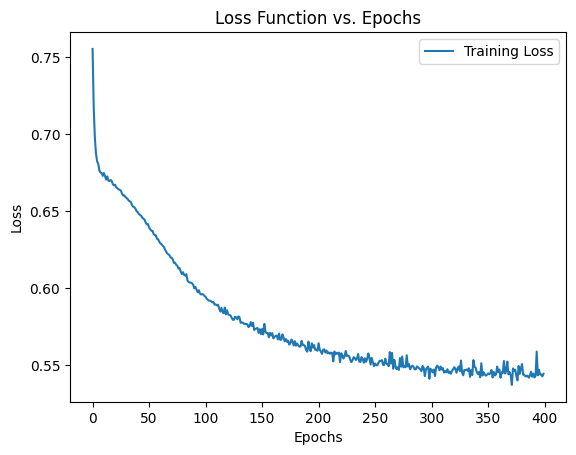

In [33]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Plot the ROC curve
fpr, tpr, _ = roc_curve(labels, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % best_model_info['Mean AUC'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(labels, y_pred_proba)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Plot Loss Function vs Epochs (this would typically come from model training history)
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs')
plt.legend()
plt.show()

1. Loss Function vs. Epochs Curve
This graph shows how the loss (in this case, likely the binary cross-entropy loss given the code's context) decreases over epochs during the training of a neural network.

Questions and Points for Discussion:

What does a declining loss curve over epochs tell us about the learning process of the model?

A declining curve suggests that the model is learning from the training data over time. The weights are being adjusted in response to the error gradient, which diminishes as the model's predictions get closer to the actual target values.
Why does the loss initially decrease sharply and then level off?

Initially, the model weights are far from their optimal values, so the gradient is steep and significant improvements are possible. As the model weights approach optimal values, the gradient becomes less steep, and the improvements in loss reduction become smaller.
Why might the loss fluctuate towards the end of training?

Fluctuations could be due to a variety of factors, including the learning rate being too high, leading to overshooting the minimum, mini-batch stochasticity if using mini-batch gradient descent, or the model beginning to overfit to the noise in the training data.
What implications do the magnitude and trend of the loss function have for the choice of an early stopping point?

If the loss levels off and starts to increase, this may be an indication of overfitting. Hence, an early stopping mechanism could be triggered to stop training when the loss stops decreasing, to prevent overfitting.

2. Precision-Recall Curve
This curve plots the precision (y-axis) versus the recall (x-axis) for different threshold values.

Questions and Points for Discussion:

How does the choice of threshold impact precision and recall?

Lowering the threshold generally increases recall but reduces precision, as the model classifies more instances as positive, including more false positives. Raising the threshold typically has the opposite effect.
Why is there a trade-off between precision and recall?

Precision is concerned with the accuracy of the positive predictions, while recall is concerned with capturing all the actual positives. In many cases, as you try to capture more positives (increasing recall), you also capture more negatives, thereby reducing precision.
What does the shape of the precision-recall curve indicate about the performance of the classifier?

A curve that stays closer to the top-right corner indicates a better performance. A curve that drops quickly toward the bottom-right indicates that the classifier's precision drops significantly as it attempts to increase recall.
In the context of imbalanced datasets, why might the precision-recall curve be more informative than the ROC curve?

Precision-recall curves are often more informative for imbalanced datasets because they focus on the performance of the classifier on the positive (minority) class, whereas ROC curves may give an overly optimistic view of the performance by also including the true negatives, which are abundant in an imbalanced dataset.

3. ROC Curve
The Receiver Operating Characteristic (ROC) curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

Questions and Points for Discussion:

What does the area under the ROC curve (AUC) represent?

The AUC represents the likelihood that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. An AUC of 0.5 represents no discriminative ability, equivalent to random guessing, while an AUC of 1.0 represents a perfect classifier.
Why might a curve be closer to the diagonal line, and what does this mean?

A curve closer to the diagonal line indicates a less effective classifier. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.

# Sebitas arch

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import tensorflow as tf
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import keras.backend as K
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

# Define input dimension based on your features
input_dim = dataset_normalized.shape[1]

# Define a function to create our custom optimizer with a learning rate placeholder
def custom_optimizer(lr=0.01):
    return CustomOptimizer(learning_rate=lr)

# Define the number of splits for StratifiedKFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

# Prepare to collect the scores
auc_scores = []
acc_scores = []
loss_values = []

# Aggregate true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Aggregate confusion matrix
conf_matrix_sum = np.zeros((2, 2))

# Iterate over each split
for train_index, test_index in skf.split(dataset_normalized, labels):
    # Generate training and validation sets
    X_train, X_val = dataset_normalized[train_index], dataset_normalized[test_index]
    y_train, y_val = labels[train_index], labels[test_index]
    
    # Create the multilayer model
    model = multilayer_model(
        input_dim=input_dim,
        num_layers=3,  # 3 hidden layers + output layer
        num_neurons_per_layer=[12, 8, 1],
        activation_function='relu',
        optimizer=custom_optimizer()
    )
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs=500, verbose=0)
    
    # Predict probabilities on the validation set
    y_pred_proba = model.predict(X_val).ravel()
    y_pred_binary = (y_pred_proba > 0.5).astype(int)
    
    # Calculate ROC AUC and accuracy and append to the list
    auc_score = roc_auc_score(y_val, y_pred_proba)
    acc_score = accuracy_score(y_val, y_pred_binary)
    auc_scores.append(auc_score)
    acc_scores.append(acc_score)
    loss_values.append(history.history['loss'])

    # Extend the aggregated lists
    all_true_labels.extend(y_val)
    all_pred_probs.extend(y_pred_proba)
    
    # Aggregate confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    conf_matrix_sum += conf_matrix

# Convert aggregated data to arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

# Calculate the mean and standard deviation of accuracy scores
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard Deviation of AUC: {std_auc:.4f}")


2023-11-06 12:01:59.764311: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-06 12:01:59.764335: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-06 12:01:59.764342: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-06 12:01:59.764544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 12:01:59.764565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-06 12:02:00.192670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 6ms/step
Mean AUC: 0.6412
Standard Deviation of AUC: 0.0948


Aggregated Confusion Matrix:
[[ 87. 107.]
 [ 49. 153.]]


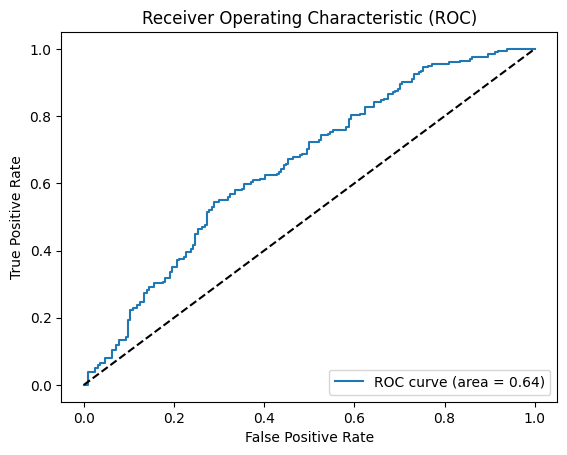

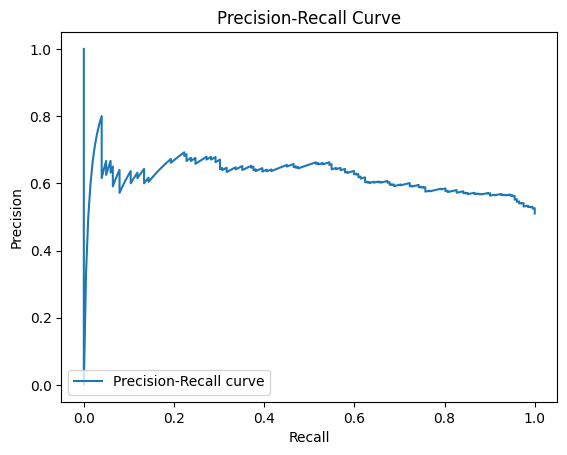

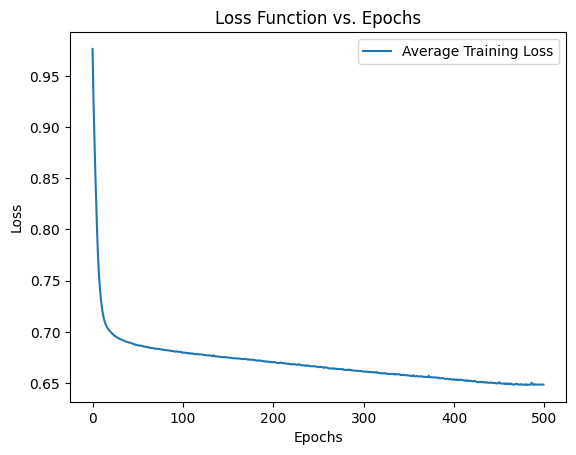

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Calculate overall confusion matrix
print("Aggregated Confusion Matrix:")
print(conf_matrix_sum)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_true_labels, all_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_true_labels, all_pred_probs)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Plot Loss Function vs. Epochs
# Average the loss across folds for each epoch
mean_loss_per_epoch = np.mean(loss_values, axis=0)
plt.figure()
plt.plot(mean_loss_per_epoch, label='Average Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs')
plt.legend()
plt.show()

# ANN using keras (no optimizer)

In [6]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Convert NumPy arrays to PyTorch tensors
X = torch.FloatTensor(dataset_normalized)
y = torch.FloatTensor(labels.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def _init_(self):
        super(SimpleCNN, self)._init_()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 13 * 13, 64)
        self.fc2 = nn.Linear(64, 1)  # Binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # For binary classification
        return x

# Initialize the CNN model
model = SimpleCNN()

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the CNN model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train.view(-1, 1, 28, 28))
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.view(-1, 1, 28, 28))
    predicted_labels = (test_outputs >= 0.5).float()  #threshold for binary classification
    auc_score = roc_auc_score(y_test, predicted_labels)
    print(f'ROC AUC Score: {auc_score:.4f}')

ValueError: optimizer got an empty parameter list

In [28]:
import tensorflow as tf
print(tf.__version__)


2.14.0


In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [38]:
# Function to create model with specified learning rate
def create_model(learning_rate=0.01, n_hidden_layers=1, n_neurons=10, activation='relu', **kwargs):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=features.shape[1], activation=activation))
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [39]:
# Define parameter grid for grid search
param_grid = {
    'epochs': [50, 100, 150],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_hidden_layers': [1, 2, 3],
    'n_neurons': [10, 20, 30],
    'build_fn__activation': ['relu', 'tanh']  # corrected parameter name
}

In [42]:
class CustomKerasClassifier(KerasClassifier):
    def set_params(self, **params):
        return super().set_params(**params)

# Create model
model = CustomKerasClassifier(build_fn=create_model, verbose=0)

In [43]:
# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(10, random_state=0, shuffle=True), scoring='roc_auc')

# Fit grid search
grid_result = grid.fit(dataset_normalized, labels)

AttributeError: 'function' object has no attribute 'set_params'

In [21]:
# Display results
print("Best AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

AttributeError: 'function' object has no attribute 'set_params'

# ANN (with optimizers - this is not valid)

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, log_loss, confusion_matrix
import numpy as np
import pandas as pd

In [6]:
# Initialize StratifiedKFold with 10 folds and a random seed for reproducibility
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# Define ANN topologies
topologies = [
    (1, 10, 'relu'),
    (2, 20, 'relu'),
    (3, 30, 'tanh'),
    (4, 40, 'tanh')
]

# Initialize lists to store metrics for each topology
conf_matrices = []
auc_scores = []
acc_scores = []
pre_scores = []
rec_scores = []
loss_scores = []

# Loop through each topology
for topology in topologies:
    # Initialize lists to store metrics for each fold
    conf_matrix_fold = []
    auc_scores_fold = []
    acc_scores_fold = []
    pre_scores_fold = []
    rec_scores_fold = []
    loss_scores_fold = []
    
    # Loop through each fold
    for train_index, test_index in skf.split(dataset_normalized, labels):
        # Split the dataset into training and testing sets
        X_train, X_test = dataset_normalized[train_index], dataset_normalized[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
        
        # Define the ANN model
        model = MLPClassifier(hidden_layer_sizes=(topology[1],) * topology[0], activation=topology[2], random_state=0)
        
        # Fit the model and make predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics and append to lists
        conf_matrix_fold.append(confusion_matrix(y_test, y_pred))
        auc_scores_fold.append(roc_auc_score(y_test, y_pred_proba))
        acc_scores_fold.append(accuracy_score(y_test, y_pred))
        pre_scores_fold.append(precision_score(y_test, y_pred))
        rec_scores_fold.append(recall_score(y_test, y_pred))
        loss_scores_fold.append(log_loss(y_test, y_pred_proba))
    
    # Append mean and standard deviation of metrics for each topology
    conf_matrices.append(np.mean(conf_matrix_fold, axis=0))
    auc_scores.append((np.mean(auc_scores_fold), np.std(auc_scores_fold)))
    acc_scores.append((np.mean(acc_scores_fold), np.std(acc_scores_fold)))
    pre_scores.append((np.mean(pre_scores_fold), np.std(pre_scores_fold)))
    rec_scores.append((np.mean(rec_scores_fold), np.std(rec_scores_fold)))
    loss_scores.append((np.mean(loss_scores_fold), np.std(loss_scores_fold)))

# Display metrics for each topology
for i, topology in enumerate(topologies):
    print(f"Topology: {topology[0]} hidden layers, {topology[1]} neurons per layer, Activation function: {topology[2]}")
    print(f"Confusion Matrix:\n{conf_matrices[i]}")
    print(f"AUC: Mean = {auc_scores[i][0]}, Std = {auc_scores[i][1]}")
    print(f"Accuracy: Mean = {acc_scores[i][0]}, Std = {acc_scores[i][1]}")
    print(f"Precision: Mean = {pre_scores[i][0]}, Std = {pre_scores[i][1]}")
    print(f"Recall: Mean = {rec_scores[i][0]}, Std = {rec_scores[i][1]}")
    print(f"Loss: Mean = {loss_scores[i][0]}, Std = {loss_scores[i][1]}")
    print("\n")

/Users/jamesleon/anaconda3/envs/URKU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jamesleon/anaconda3/envs/URKU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jamesleon/anaconda3/envs/URKU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jamesleon/anaconda3/envs/URKU/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye